In [1]:
import torch
import os
import matplotlib.pyplot as plt
os.chdir("..")

from dreamy.models.SpatialTemporal.STGCN import STGCN
from dreamy.data import UniversalDataset
from dreamy.utils import utils

# initial settings
device = torch.device('cpu')
torch.manual_seed(7)

lookback = 75 # inputs size
horizon = 25 # predicts size

epochs = 50 # training epochs
batch_size = 50 # training batch size

In [2]:
# load toy dataset
dataset = UniversalDataset()
dataset.load_toy_dataset()

# preprocessing
features, mean, std = utils.normalize(dataset.x)
adj_norm = utils.normalize_adj(dataset.graph)

features = features.to(device)
adj_norm = adj_norm.to(device)

# prepare datasets
train_rate = 0.6 
val_rate = 0.2

split_line1 = int(features.shape[0] * train_rate)
split_line2 = int(features.shape[0] * (train_rate + val_rate))

train_original_data = features[:split_line1, :, :]
val_original_data = features[split_line1:split_line2, :, :]
test_original_data = features[split_line2:, :, :]

train_input, train_target = dataset.generate_dataset(X = train_original_data, Y = train_original_data[:, :, 0], lookback_window_size = lookback, horizon_size = horizon, permute = True)
val_input, val_target = dataset.generate_dataset(X = val_original_data, Y = val_original_data[:, :, 0], lookback_window_size = lookback, horizon_size = horizon, permute = True)
test_input, test_target = dataset.generate_dataset(X = test_original_data, Y = test_original_data[:, :, 0], lookback_window_size = lookback, horizon_size = horizon, permute = True)

# prepare model
model = STGCN(
            num_nodes = adj_norm.shape[0],
            num_features = train_input.shape[3],
            num_timesteps_input = lookback,
            num_timesteps_output = horizon
            ).to(device = device)

In [3]:
# training
model.fit(
        train_input = train_input, 
        train_target = train_target, 
        graph = adj_norm, 
        val_input = val_input, 
        val_target = val_target, 
        verbose = True, 
        batch_size = batch_size,
        epochs = epochs)

  2%|▏         | 1/50 [00:05<04:24,  5.40s/it]

######### epoch:0
Training loss: 1.134373277425766
Validation loss: 1.15967857837677


100%|██████████| 50/50 [04:23<00:00,  5.28s/it]



Final Training loss: 0.20012046098709108
Final Validation loss: 0.493730366230011


In [4]:
# evaluate
out = model.predict(feature = test_input, graph = adj_norm)
preds = out.detach().cpu() * std[0] + mean[0]
targets = test_target.detach().cpu() * std[0] + mean[0]
# MAE
mae = utils.get_MAE(preds, targets)
print(f"MAE: {mae.item()}")

MAE: 258.00482177734375


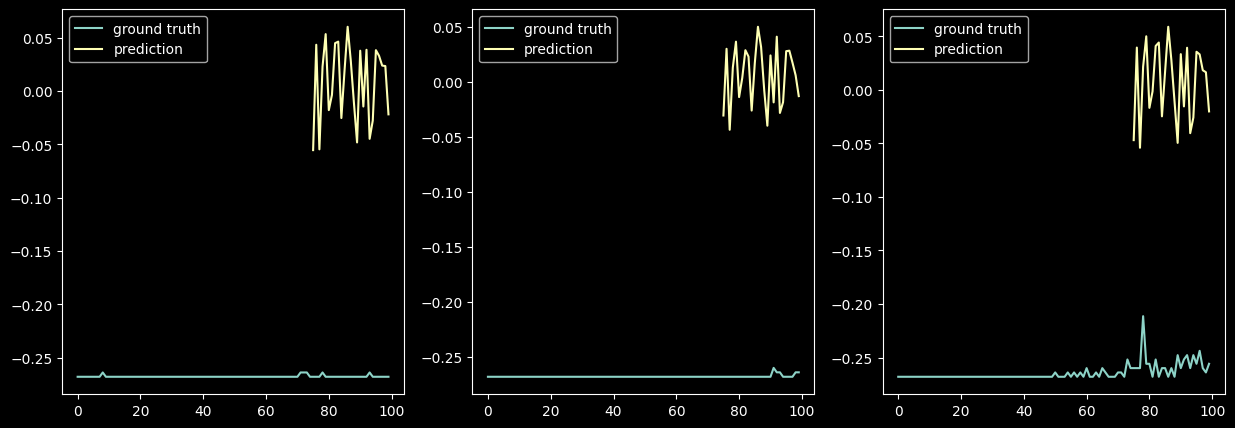

In [5]:
# visualization
out = model.predict(feature = train_input, graph = adj_norm).detach().cpu()

sample = 28

plt.figure(figsize=(15 ,5))
for i in range(1, 4):
    sample_input = train_input[sample, i, :, 0]
    sample_output = out[sample, i, :]
    sample_target = train_target[sample, i, :]

    vis_data = torch.cat([sample_input, sample_target]).numpy()
    
    plt.subplot(1, 3, i)
    rng = list(range(lookback+horizon))
    plt.plot(rng, vis_data, label = "ground truth")
    plt.plot(rng[lookback:lookback+horizon], sample_output.numpy(), label = "prediction")
    plt.legend()


plt.show()